# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=2


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
##################### Write your answer here ##################
# Define the loss function
#criterion = criterion = nn.CrossEntropyLoss()
#criterion = criterion = nn.L1Loss()
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = ((1 - pt) ** self.gamma * CE_loss)
        return torch.mean(focal_loss) if self.reduction == 'mean' else torch.sum(focal_loss)

        

# Example usage:
criterion = FocalLoss(gamma=2)
###############################################################

In [9]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [10]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################
    
    return output, loss

### Model Training

In [15]:
#L1Loss
import torch.nn.functional as F

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target = F.one_hot(target, NUM_CLASS)
        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        target_indices = torch.argmax(target, dim=1)  
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target_indices)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target = F.one_hot(target, NUM_CLASS)
            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            target_indices = torch.argmax(target, dim=1)  
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target_indices)

        val_loss = val_loss / len(test_set)

Epoch: 1/30 Train Loss: 0.0009 Acc: 0.1010
Begin test......
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.1002
Begin test......
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.1000
Begin test......
Epoch: 4/30 Train Loss: 0.0009 Acc: 0.1001
Begin test......
Epoch: 5/30 Train Loss: 0.0009 Acc: 0.0995
Begin test......
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.0999
Begin test......
Epoch: 7/30 Train Loss: 0.0008 Acc: 0.0961
Begin test......
Epoch: 8/30 Train Loss: 0.0008 Acc: 0.1012
Begin test......
Epoch: 9/30 Train Loss: 0.0008 Acc: 0.0981
Begin test......
Epoch: 10/30 Train Loss: 0.0008 Acc: 0.0968
Begin test......
Epoch: 11/30 Train Loss: 0.0008 Acc: 0.1003
Begin test......
Epoch: 12/30 Train Loss: 0.0008 Acc: 0.0986
Begin test......
Epoch: 13/30 Train Loss: 0.0008 Acc: 0.1003
Begin test......
Epoch: 14/30 Train Loss: 0.0008 Acc: 0.0992
Begin test......
Epoch: 15/30 Train Loss: 0.0008 Acc: 0.0994
Begin test......
Epoch: 16/30 Train Loss: 0.0008 Acc: 0.1017
Begin test......
Epoch: 17/30 Train Loss: 0.0008 A

In [11]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0124 Acc: 0.2186
Begin test......
Test Loss: 0.0106 Acc: 0.2910
Epoch: 2/30 Train Loss: 0.0107 Acc: 0.2937
Begin test......
Test Loss: 0.0103 Acc: 0.3129
Epoch: 3/30 Train Loss: 0.0103 Acc: 0.3124
Begin test......
Test Loss: 0.0098 Acc: 0.3341
Epoch: 4/30 Train Loss: 0.0102 Acc: 0.3232
Begin test......
Test Loss: 0.0095 Acc: 0.3426
Epoch: 5/30 Train Loss: 0.0100 Acc: 0.3280
Begin test......
Test Loss: 0.0095 Acc: 0.3543
Epoch: 6/30 Train Loss: 0.0114 Acc: 0.2693
Begin test......
Test Loss: 0.0108 Acc: 0.2801
Epoch: 7/30 Train Loss: 0.0116 Acc: 0.2545
Begin test......
Test Loss: 0.0115 Acc: 0.2718
Epoch: 8/30 Train Loss: 0.0118 Acc: 0.2437
Begin test......
Test Loss: 0.0120 Acc: 0.2609
Epoch: 9/30 Train Loss: 0.0116 Acc: 0.2565
Begin test......
Test Loss: 0.0111 Acc: 0.2665
Epoch: 10/30 Train Loss: 0.0115 Acc: 0.2542
Begin test......
Test Loss: 0.0114 Acc: 0.2551
Epoch: 11/30 Train Loss: 0.0134 Acc: 0.1722
Begin test......
Test Loss: 0.0136 Acc: 0.1585
Epoch: 1

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [ ]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [ ]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

# Calculate class probabilities using softmax
probabilities = torch.softmax(outputs, dim=1)

# Get the predicted label as the class with the highest probability
predict_label = torch.argmax(probabilities, dim=1)

In [ ]:
# Assuming you have the class labels defined somewhere
class_labels = ["class1", "class2", "class3", ...]  # Replace with your actual class labels

# Access the predicted class and probability
predicted_class = class_names[predict_label[0].item()]  # Corrected
predicted_probability = probabilities[0][predict_label[0]].item()  # Corrected

image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

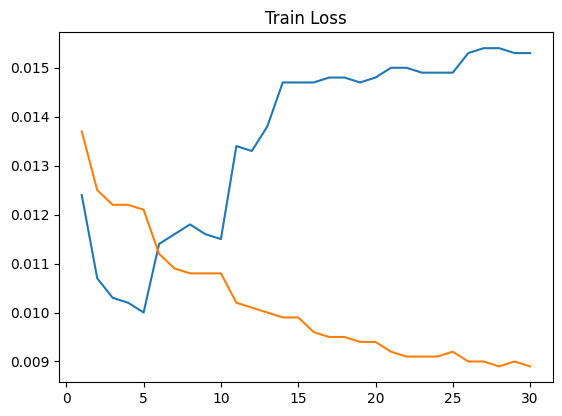

In [14]:
import matplotlib.pyplot as plt

# Data for gamma=2
epochs_gamma_2 = list(range(1, 31))
train_loss_gamma_2 = [
    0.0124, 0.0107, 0.0103, 0.0102, 0.0100, 0.0114, 0.0116, 0.0118, 0.0116, 0.0115,
    0.0134, 0.0133, 0.0138, 0.0147, 0.0147, 0.0147, 0.0148, 0.0148, 0.0147, 0.0148,
    0.0150, 0.0150, 0.0149, 0.0149, 0.0149, 0.0153, 0.0154, 0.0154, 0.0153, 0.0153
]
train_acc_gamma_2 = [
    0.2186, 0.2937, 0.3124, 0.3232, 0.3280, 0.2693, 0.2545, 0.2437, 0.2565, 0.2542,
    0.1722, 0.1755, 0.1497, 0.0987, 0.0986, 0.1008, 0.1007, 0.0994, 0.1020, 0.1007,
    0.0995, 0.1008, 0.1000, 0.0996, 0.1015, 0.0997, 0.1009, 0.0991, 0.1009, 0.1019
]
test_loss_gamma_2 = [
    0.0106, 0.0103, 0.0098, 0.0095, 0.0095, 0.0108, 0.0115, 0.0120, 0.0111, 0.0114,
    0.0136, 0.0134, 0.0148, 0.0148, 0.0149, 0.0149, 0.0150, 0.0149, 0.0148, 0.0148,
    0.0150, 0.0149, 0.0153, 0.0151, 0.0152, 0.0152, 0.0155, 0.0151, 0.0151, 0.0156
]
test_acc_gamma_2 = [
    0.2910, 0.3129, 0.3341, 0.3426, 0.3543, 0.2801, 0.2718, 0.2609, 0.2665, 0.2551,
    0.1585, 0.1741, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
    0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000
]

# Data for gamma=0.5
epochs_gamma_05 = list(range(1, 31))
train_loss_gamma_05 = [
    0.0137, 0.0125, 0.0122, 0.0122, 0.0121, 0.0112, 0.0109, 0.0108, 0.0108, 0.0108,
    0.0102, 0.0101, 0.0100, 0.0099, 0.0099, 0.0096, 0.0095, 0.0095, 0.0094, 0.0094,
    0.0092, 0.0091, 0.0091, 0.0091, 0.0092, 0.0090, 0.0090, 0.0089, 0.0090, 0.0089
]
train_acc_gamma_05 = [
    0.2914, 0.3525, 0.3625, 0.3676, 0.3723, 0.4127, 0.4330, 0.4365, 0.4402, 0.4401,
    0.4729, 0.4743, 0.4817, 0.4850, 0.4843, 0.5041, 0.5072, 0.5101, 0.5124, 0.5128,
    0.5231, 0.5270, 0.5264, 0.5299, 0.5259, 0.5314, 0.5319, 0.5381, 0.5375, 0.5362
]
test_loss_gamma_05 = [
    0.0130, 0.0112, 0.0117, 0.0119, 0.0118, 0.0103, 0.0104, 0.0100, 0.0103, 0.0099,
    0.0094, 0.0092, 0.0100, 0.0093, 0.0094, 0.0089, 0.0091, 0.0088, 0.0087, 0.0088,
    0.0086, 0.0085, 0.0086, 0.0085, 0.0085, 0.0085, 0.0085, 0.0084, 0.0084, 0.0084
]
test_acc_gamma_05 = [
    0.3135, 0.4246, 0.3981, 0.3943, 0.3935, 0.4660, 0.4633, 0.4827, 0.4727, 0.4925,
    0.5086, 0.5255, 0.4949, 0.5292, 0.5099, 0.5425, 0.5267, 0.5423, 0.5491, 0.5476,
    0.5599, 0.5556, 0.5563, 0.5589, 0.5644, 0.5664, 0.5658, 0.5682, 0.5733, 0.5670
]


# Plotting
plt.figure(figsize=(14, 10))

# Subplot for Train Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_gamma_2, train_loss_gamma_2, label='Train Loss (gamma=2)')
plt.plot(epochs_gamma_05, train_loss_gamma_05, label='Train Loss (gamma=0.5)')
plt.title('Train Loss')
plt.plot
